## Global

In [261]:
asap_project_id = 'ASAP-EVD68-3CLPRO'
xchem_project_id = 'D68EV3CPROA'

labels = {'SMILES': 'SMILES',
         'XChem code': f'fragment_XChem-code',
         'method': 'fragment_method-name',
         'notes': 'fragment_notes',
         'keywords': 'fragment_method-keywords',
         'date': f'fragment_method-date',
         'institution': f'fragment_submitter_institution',
         'name': f'fragment_submitter_name',
         'email': f'fragment_submitter_email',
         'ref XChem': f'fragment_reference_XChem',
         'ref vcid': f'fragment_reference_vcid',
         'ref SMILES': f'fragment_reference_SMILES'
         }

## Deal with XChem to ASAP conversion

Xref XChem to ASAP to make `xchem2asap.json`

In [92]:
metadata = pd.read_csv('D68EV3CPROA_metadata.csv')
metadata['RealCrystalName'] = metadata.RealCrystalName.str.replace('D68EV3CPROA-', '')
xchem2smiles: pdt.Series[str]  = metadata.drop_duplicates('RealCrystalName').set_index('RealCrystalName').new_smiles.str.replace('Cl.','')
xchem2mol: pdt.Series[Chem.Mol] = xchem2smiles.apply(Chem.MolFromSmiles)
xchem2fp: pdt.Series[DataStructs] = xchem2mol.apply(functools.partial(AllChem.GetMorganFingerprintAsBitVect, radius=3))
originals: List[str] = metadata.loc[~metadata.alternate_name.str.contains('ASAP')].RealCrystalName.to_list()

In [250]:
import pandas as pd
import pandera.typing as pdt
import functools
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, DataStructs
from typing import List


asapt: pd.DataFrame =  pd.concat([pd.read_csv('submission-ASAP-DESIGN-996.csv'),
                                  pd.read_csv('submission-ASAP-DESIGN-987.csv'),
                                  pd.read_csv('submission-ASAP-DESIGN-990.csv')])

asap2smiles: pdt.Series[str] = asapt.drop_duplicates('SMILES').set_index('vc_id_postera').original_query
asap2mol: pdt.Series[Chem.Mol] = asap2smiles.apply(Chem.MolFromSmiles)
asap2fp: pdt.Series[DataStructs] = asap2mol.apply(functools.partial(AllChem.GetMorganFingerprintAsBitVect, radius=3))

In [251]:
xchem2asap = {}
missing = []

for xchem_code, xchem_fp in xchem2fp.items():
    if xchem_code not in originals:
        continue
    for asap_code, asap_fp in asap2fp.items():
        if xchem_fp == asap_fp:
            xchem2asap[xchem_code] = asap_code
            break
    else:
        missing.append(xchem_code)

In [252]:
if missing:
    pd.DataFrame({labels['XChem code']: missing,
                  labels['method']: 'XChem initial screen',
                  labels['notes']: 'unidentified library',
                  'SMILES': [xchem2smiles[code] for code in missing]})\
      .to_csv('missing_codes.csv', index=False)
    print('Please upload')
else:
    print('All good now')

All good now


COCCN(C)S(=O)(=O)NCc1ccc2c(c1)OCO2


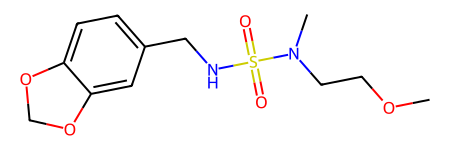

In [253]:
print( xchem2smiles['x2021'] )
xchem2mol['x2021'] 

In [254]:
xchem2asap['x2099'] = 'ASAP-VC-5892'
xchem2asap['x1919'] = 'ASAP-VC-6113'
xchem2asap['x2149'] = 'ASAP-VC-7470'
xchem2asap['x2021'] = 'ASAP-VC-6077'
xchem2asap[''] = ''
xchem2asap[''] = ''

In [255]:
import json

with open('xchem2asap.json', 'w') as fh:
    json.dump(xchem2asap, fh)

## Conflict test
I think this did not delete previous vcid

In [256]:
import pandas as pd

libraries = pd.read_csv('combined-XChem-libraries.csv', index_col=0)
reduced  =  libraries.drop_duplicates(['SMILES', 'library']) \
                     .groupby('SMILES').agg({'library': ','.join, 
                                             'Id':set }) \
                     .reset_index()
reduced['Id'] = reduced['Id'].apply(','.join)
# reduced['designer_institution'] = 'XChem'
# reduced['design_rationale'] = 'XChem initial soak'
# reduced['design_submission_source_link'] = 'https://www.diamond.ac.uk/industry/Techniques-Available/Integrated-Structural-Biology/Fragment-Screening---XChem/Fragment-Libraries.html'
# reduced['designer_name'] = 'XChem team'
# reduced['design_notes'] = 'Fragment libraries: '+reduced.design_notes
reduced['FP'] = reduced.SMILES.apply(Chem.MolFromSmiles).apply(functools.partial(AllChem.GetMorganFingerprintAsBitVect, radius=3))

In [257]:
xchem2libary = {}

originals = list(set(originals))
for code in originals:
    matched = reduced.loc[xchem2fp[code] == reduced.FP]
    if len(matched):
        xchem2libary[code] = matched.library.iloc[0]
    else:
        xchem2libary[code] = 'unknown'
        
pd.DataFrame({labels['XChem code']: originals,
              labels['method']: 'XChem initial screen',
              labels['notes']: [xchem2libary[code] for code in originals],
              labels['keywords']: 'screen',
              labels['institution']: 'DLS XChem',
              labels['date']: '01-01-2001',
              'SMILES': [xchem2smiles[code] for code in originals]})\
      .to_csv('xstal.csv', index=False)

## Fix Csets

In [266]:
import requests
import pandas as pd
import operator
import os
from pathlib import Path

available = [datapath.name for datapath in Path('media_compounds_sets').glob('*.sdf')]

cset_metadata = pd.DataFrame( requests.get('https://fragalysis.diamond.ac.uk/api/compound-sets/').json()['results'] )
targets = pd.DataFrame( requests.get('https://fragalysis.diamond.ac.uk/api/targets/').json()['results'] )
id2name = targets.set_index('id').title.to_dict()
cset_metadata['target_name'] = cset_metadata.target.map(id2name)
cset_metadata['sdf_name'] = cset_metadata.submitted_sdf.fillna('').apply(os.path.split).apply(operator.itemgetter(-1))
cset_metadata['locally_available'] = cset_metadata['sdf_name'].isin(available)

In [267]:
print('These are unavailable')
cset_metadata.loc[(cset_metadata.target_name == 'D68EV3CPROA') & ~cset_metadata.locally_available].unique_name.to_list()

These are unavailable


['StephWills-fragnetv1',
 'LucyVost-STRIFE-fragmentelaboration',
 'PDB-StolenfromPDB']

In [270]:
output_path = Path('output')
output_path.mkdir(exist_ok=True)

def desufficify(xchem_codes: str):
    return xchem_codes.split('_')[0]

def convert_codes_to_asap(xchem_codes: str):
    return ' '.join([xchem2asap[desufficify(xchem_code)] for xchem_code in xchem_codes.split(',')])

def convert_codes_to_smiles(xchem_codes: str):
    return '.'.join([xchem2smiles[desufficify(xchem_code)] for xchem_code in xchem_codes.split(',')])

fixer_uppers = cset_metadata.loc[(cset_metadata.target_name == xchem_project_id) & cset_metadata.locally_available]

csets = {}
for i, row in fixer_uppers.iterrows():
    cset = PandasTools.LoadSDF((Path('media_compounds_sets') / row.sdf_name).as_posix(), smilesName='SMILES', embedProps=True)
    header = cset.iloc[0]
    cset = cset.iloc[1:].copy()
    if len(cset) == 0:
        print(row.unique_name, 'EMPTY')
        continue
    if 'STRIFE' in row.unique_name:
        keywords = 'STRIFE,de-novo,AI,analog-by-catalog'
    elif 'fragnet' in row.unique_name.lower():
        keywords = 'fragnet,catalog-enumeration,linker,substructure-based'
    elif 'ROCS' in row.unique_name:
        keywords = 'ROCS,shape&color,catalog-enumeration'
    elif 'Manual' in row.unique_name:
        keywords = 'by-eye'
    elif 'Arthor' in row.unique_name:
        keywords = 'Arthor,catalog-enumeration,linker'
    elif 'Fragmenstein' in row.unique_name:
        keywords = 'Fragmenstein,de-novo,merger,analog-by-catalog,linker'
    else:
        raise ValueError(row.unique_name)
    cset[labels['keywords']] = keywords
    cset[labels['method']] = header.method
    cset[labels['name']] = header.submitter_name
    cset[labels['email']] = header.submitter_email
    cset[labels['institution']] = header.submitter_institution
    cset[labels['date']] = header.generation_date
    cset[labels['ref XChem']] = cset.ref_mols
    cset[labels['ref vcid']] = cset.ref_mols.apply(convert_codes_to_asap)
    cset[labels['ref SMILES']] = cset.ref_mols.apply(convert_codes_to_smiles)
    cset[labels['notes']] = row.unique_name
    
    
    munged = cset[[col for col in cset.columns if col in labels.values()]]
    
    cset['fp'] = cset.ROMol.apply(functools.partial(AllChem.GetMorganFingerprintAsBitVect, radius=3))
    for xchem_code, xchem_fp in xchem2fp.items():
            matched = cset['fp'] == xchem_fp
            if matched.any():
                print(xchem_code)
                munged.loc[matched, labels['XChem code']] = xchem_code
    
    csets[row.unique_name] = cset.copy()
                
    print('\n\n****************')
    print(f'P2. Design wave 1. Fragalysis upload by {header.submitter_name} ("{row.unique_name}")')
    print(' '.join(set(munged[labels['ref vcid']].to_list())))

    munged.fillna('').to_csv(output_path / (row.unique_name + '.csv'), index=False)



****************
P2. Design wave 1. Fragalysis upload by Steph Wills ("StephWills-fragnetv2_named")
ASAP-VC-13694 ASAP-VC-13641 ASAP-VC-13680 ASAP-VC-13694 ASAP-VC-13641 ASAP-VC-13605 ASAP-VC-13641 ASAP-VC-13686 ASAP-VC-13636 ASAP-VC-13641 ASAP-VC-13604 ASAP-VC-13636 ASAP-VC-13641 ASAP-VC-13645 ASAP-VC-13641 ASAP-VC-13694 ASAP-VC-13644 ASAP-VC-13636 ASAP-VC-13645 ASAP-VC-13641 ASAP-VC-13641 ASAP-VC-13636 ASAP-VC-13644 ASAP-VC-13694


****************
P2. Design wave 1. Fragalysis upload by Steph Wills ("StephWills-fragnetv3_corrected")
ASAP-VC-13694 ASAP-VC-13641 ASAP-VC-13686 ASAP-VC-13641 ASAP-VC-13605 ASAP-VC-13641 ASAP-VC-13641 ASAP-VC-13686 ASAP-VC-13641 ASAP-VC-13645 ASAP-VC-13636 ASAP-VC-13641 ASAP-VC-13641 ASAP-VC-13694 ASAP-VC-13641 ASAP-VC-13636 ASAP-VC-13645 ASAP-VC-13641 ASAP-VC-13641 ASAP-VC-13605
x2135


****************
P2. Design wave 1. Fragalysis upload by Matteo Ferla ("MatteoFerla-ROCS&PyRosetta-filtering")
ASAP-VC-13605 ASAP-VC-13629 ASAP-VC-13686 ASAP-VC-13593 A

/var/folders/70/28pvwk5s63q9xd4mwxj039hm0000gp/T/ipykernel_98294/3164870932.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  munged.loc[matched, labels['XChem code']] = xchem_code
[18:25:34] ERROR: Counts line too short: '' on line3225
[18:25:34] ERROR: moving to the beginning of the next molecule
/var/folders/70/28pvwk5s63q9xd4mwxj039hm0000gp/T/ipykernel_98294/3164870932.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  munged.loc[matched, labels['XChem code']] = xchem_code




****************
P2. Design wave 1. Fragalysis upload by Lucy Vost ("LucyVost-STRIFE")
ASAP-VC-13605
x2135
x2148
x2149


****************
P2. Design wave 1. Fragalysis upload by Matteo Ferla ("MatteoFerla-Manual-Submission")
ASAP-VC-13644 ASAP-VC-13686 ASAP-VC-13680 ASAP-VC-13664 ASAP-VC-13645 ASAP-VC-13680 ASAP-VC-13645 ASAP-VC-13664 ASAP-VC-13664 ASAP-VC-13641 ASAP-VC-13641 ASAP-VC-13686 ASAP-VC-13644 ASAP-VC-13641 ASAP-VC-13645 ASAP-VC-13641 ASAP-VC-13686 ASAP-VC-13596 ASAP-VC-13645 ASAP-VC-13664 ASAP-VC-13680


****************
P2. Design wave 1. Fragalysis upload by Matteo Ferla ("MatteoFerla-ArthorianQuest-sulfonamide")
ASAP-VC-13680 ASAP-VC-13664 ASAP-VC-13645


****************
P2. Design wave 1. Fragalysis upload by Matteo Ferla ("MatteoFerla-Fragmenstein-Tris")
ASAP-VC-6113 ASAP-VC-13604 ASAP-VC-6113 ASAP-VC-13629 ASAP-VC-13589 ASAP-VC-13593 ASAP-VC-13589 ASAP-VC-13694 ASAP-VC-5892 ASAP-VC-13645 ASAP-VC-13589 ASAP-VC-13651 ASAP-VC-13641 ASAP-VC-13646 ASAP-VC-13627 ASAP-VC-1

## Fix Beth's sheet

In [76]:
print( xchem2smiles['x1427'] )
Chem.MolToSmiles(xchem2mol['x1427'])

BrC1=CON=C1


'Brc1cnoc1'

In [32]:
functools.partial(AllChem.GetMorganFingerprintAsBitVect, radius=3)( xchem2mol[0])

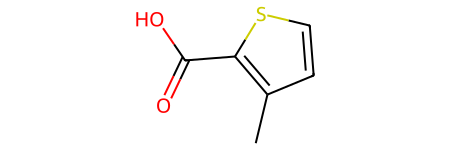

In [23]:
xchem2mol[0]

In [26]:
help(AllChem.GetMorganFingerprintAsBitVect)

Help on built-in function GetMorganFingerprintAsBitVect in module rdkit.Chem.rdMolDescriptors:

GetMorganFingerprintAsBitVect(...)
    GetMorganFingerprintAsBitVect( (Mol)mol, (int)radius [, (int)nBits=2048 [, (AtomPairsParameters)invariants=[] [, (AtomPairsParameters)fromAtoms=[] [, (bool)useChirality=False [, (bool)useBondTypes=True [, (bool)useFeatures=False [, (AtomPairsParameters)bitInfo=None [, (bool)includeRedundantEnvironments=False]]]]]]]]) -> ExplicitBitVect :
        Returns a Morgan fingerprint for a molecule as a bit vector
    
        C++ signature :
            ExplicitBitVect* GetMorganFingerprintAsBitVect(RDKit::ROMol,unsigned int [,unsigned int=2048 [,boost::python::api::object=[] [,boost::python::api::object=[] [,bool=False [,bool=True [,bool=False [,boost::python::api::object=None [,bool=False]]]]]]]])

